# Building OCR application

In [1]:
# Useful imports
from ocr.ocr import OCR
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# Function for presenting images
def show_image(image, title, cmap=None):
    plt.figure(figsize=(9, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Building simple OCR 

To extract text from a file, we must identify each letter within our image. To achieve this, I integrated functions from a previous notebook into a ```PatternFinder``` class. This class comprises methods for segmenting text, detecting individual letter patterns, and analyzing their characteristics. The OCR class leverages this finder to process each letter and symbol in the correct sequence, as certain letters may be components of others.

The OCR application also requires input of the font name and size to generate accurate font patterns. We also need to provide a space multiplier, which is dependent on the height of the letters. These parameters are passed to the ```FontCreator``` class, which is responsible for generating all necessary images of letters and symbols, as well as a composite image containing all patterns. This composite image is then aligned with the original image to ensure that every pattern is present and available for recognition, thereby maximizing the accuracy of the recognition process.

The OCR function ```image_to_text``` processes a connected image and inverts its colors. For each letter in the specified order, it identifies its occurrences and removes them from the original image. As a result, the image becomes progressively darker. Once all letters are found, they are sorted by lines to generate the final text output.

The order of the letters was determined by reversing the frequency of occurrences detected from sample images containing all the letters except for the dot which is at the end of the order.

In [3]:
ocr = OCR()
ocr.upload_font('fonts/arial.ttf', 50, 0.25)
print(ocr.letter_order)

['a', 'b', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'o', 'p', 'q', 's', 't', 'u', 'w', 'x', 'y', 'z', '0', '1', '2', '4', '5', '6', '7', '8', '9', '?', '!', 'n', 'v', '3', 'c', 'l', 'r', 'i', ',', '.']


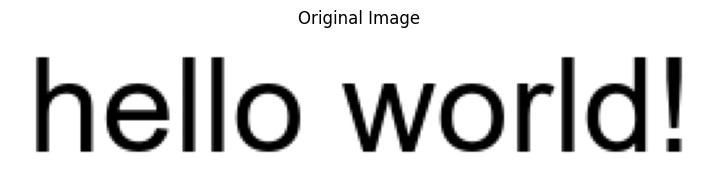

hello world!


In [4]:
hello = Image.open('images/hello_world.png')
show_image(hello, 'Original Image', cmap='gray')
text = ocr.image_to_text(hello)
print(text)


To assist with generating test images, a class ```FileCreator``` was created that generates images with specified font type and size. This class also allows for rotating the image and adding noise to simulate conditions commonly found in online files.

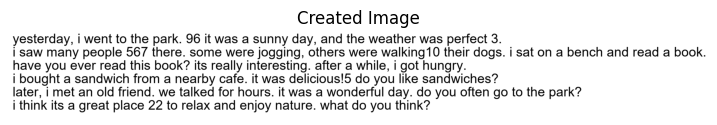

In [5]:
from creators.file_creator import FileCreator

creator = FileCreator()
test_text = 'yesterday, i went to the park. 96 it was a sunny day, and the weather was perfect 3.\ni saw many people 567 there. some were jogging, others were walking10 their dogs. i sat on a bench and read a book.\nhave you ever read this book? its really interesting. after a while, i got hungry.\ni bought a sandwich from a nearby cafe. it was delicious!5 do you like sandwiches?\nlater, i met an old friend. we talked for hours. it was a wonderful day. do you often go to the park?\ni think its a great place 22 to relax and enjoy nature. what do you think?'
creator.create_text(test_text, 'fonts/arial.ttf', 50, 'park')
test_image = Image.open('images/park.png')
show_image(test_image, 'Created Image', cmap='gray')

In [6]:
text = ocr.image_to_text(test_image)
print(text)

yesterday, i went to the park. 96 it was a sunny day, and the weather was perfect 3.
i saw many people 567 there. some were jogging, others were walking10 their dogs. i sat on a bench and read a book.
have you ever read this book? its really interesting. after a while, i got hungry.
i bought a sandwich from a nearby cafe. it was delicious!5 do you like sandwiches?
later, i met an old friend. we talked for hours. it was a wonderful day. do you often go to the park?
i think its a great place 22 to relax and enjoy nature. what do you think?


The font used in the previous images is Arial, a sans-serif font. OCR should accurately recognize text regardless of font type, so it should also be tested with a serif font.

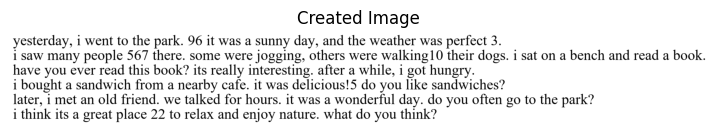

In [7]:
# Font - times new roman
creator = FileCreator()
creator.create_text(test_text, 'fonts/times.ttf', 50, 'park_serif')
test_image_serif = Image.open('images/park_serif.png')
show_image(test_image_serif, 'Created Image', cmap='gray')

In [8]:
ocr.upload_font('fonts/times.ttf', 50, 0.2)
print(ocr.letter_order)
text_serif = ocr.image_to_text(test_image_serif)
print(text_serif)

['a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'm', 'o', 'p', 'q', 'r', 's', 't', 'u', 'w', 'x', 'y', 'z', '0', '2', '3', '4', '5', '6', '7', '8', '9', '?', ',', 'c', 'n', 'v', '1', 'l', '!', '.']
yesterday, i went to the park. 96 it was a sunny day, and the weather was perfect 3.
i saw many people 567 there. some were jogging, others were walking10 their dogs. i sat on a bench and read a book.
have you ever read this book? its really interesting. after a while, i got hungry.
i bought a sandwich from a nearby cafe. it was delicious!5 do you like sandwiches?
later, i met an old friend. we talked for hours. it was a wonderful day. do you often go to the park?
i think its a great place 22 to relax and enjoy nature. what do you think?


The primary challenge in developing OCR technology lies in determining the appropriate sensitivity for each font. Sensitivity levels can vary based on the sequence of letters and the font type. For example, serif fonts like Times New Roman are more difficult to remove from an image without affecting other characters. Hence, it becomes necessary to adjust sensitivity levels either lowering or raising them in order to identify patterns of damaged letters accurately. Second challenge is finding right spacing for font.

## Correctness tests

When dealing with lengthy text, simply assuming that everything is in its correct place might not suffice. In such cases, we employ the Levenshtein distance, which quantifies the number of changes needed to transform one string into another, thereby giving us an accurate measure of the text's integrity. This metric can then be converted into a percentage representing the accuracy of the OCR output.

In [9]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)

    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


In [10]:
# Test of the previous texts
print("Number of changes: ", levenshtein_distance(test_text, text))
print("Number of changes: ", levenshtein_distance(test_text, text_serif))

Number of changes:  0
Number of changes:  0


Number of changes equals 0 which means that both texts are the same.

In [11]:
# Transforming the number of changes to percents
def change_to_procents(changes, text, text_test):
    maxi = max(len(text), len(text_test))
    return (1 - changes / maxi) * 100

print("Percents of similarity: ", change_to_procents(levenshtein_distance(test_text, text), test_text, text), "%")
print("Percents of similarity: ", change_to_procents(levenshtein_distance(test_text, text_serif), test_text, text_serif), "%")

Percents of similarity:  100.0 %
Percents of similarity:  100.0 %


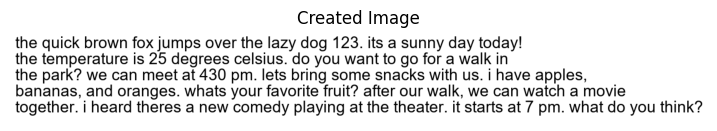

In [12]:
test_text1 = 'the quick brown fox jumps over the lazy dog 123. its a sunny day today!\nthe temperature is 25 degrees celsius. do you want to go for a walk in\nthe park? we can meet at 430 pm. lets bring some snacks with us. i have apples,\nbananas, and oranges. whats your favorite fruit? after our walk, we can watch a movie\ntogether. i heard theres a new comedy playing at the theater. it starts at 7 pm. what do you think?'
creator.create_text(test_text1, 'fonts/arial.ttf', 30, 'movie')
test_image1 = Image.open('images/movie.png')
show_image(test_image1, 'Created Image', cmap='gray')   

In [13]:
ocr.upload_font('fonts/arial.ttf', 30, 0.2)
text1 = ocr.image_to_text(test_image1)
print(text1)

the quick brown fox jumps over the lazy dog 123. its a sunny day today!
the temperature is 25 degrees celsius. do you want to go for a walk in
the park? we can meet at 430 pm. lets bring some snacks with us. i have apples,
bananas, and oranges. whats your favorite fruit? after our walk, we can watch a movie
together. i heard theres a new comedy playing at the theater. it starts at 7 pm. what do you think?


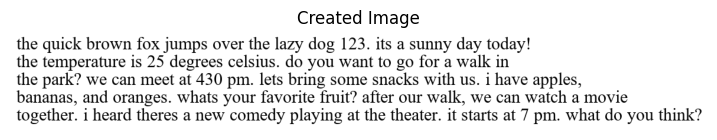

In [14]:
creator.create_text(test_text1, 'fonts/times.ttf', 30, 'movie_serif')
test_image1_serif = Image.open('images/movie_serif.png')
show_image(test_image1_serif, 'Created Image', cmap='gray')

In [15]:
ocr.upload_font('fonts/times.ttf', 30, 0.2)
text1_serif = ocr.image_to_text(test_image1_serif)
print(text1)

the quick brown fox jumps over the lazy dog 123. its a sunny day today!
the temperature is 25 degrees celsius. do you want to go for a walk in
the park? we can meet at 430 pm. lets bring some snacks with us. i have apples,
bananas, and oranges. whats your favorite fruit? after our walk, we can watch a movie
together. i heard theres a new comedy playing at the theater. it starts at 7 pm. what do you think?


In [16]:
print("Percents of similarity: ", change_to_procents(levenshtein_distance(test_text1, text1), test_text1, text1), "%")
print("Percents of similarity: ", change_to_procents(levenshtein_distance(test_text1, text1_serif), test_text1, text1_serif), "%")

Percents of similarity:  100.0 %
Percents of similarity:  96.32352941176471 %


We've observed that OCR accuracy tends to decrease when dealing with smaller serif fonts. This is primarily due to the fact that removing individual characters from smaller serif fonts can have a more significant impact on the overall image integrity. This effect is particularly pronounced in serif fonts, where characters are intricately designed and placed closer together, making it challenging for OCR algorithms to accurately interpret each character in isolation. This can be corrected by changing sensitivity for exact font size.

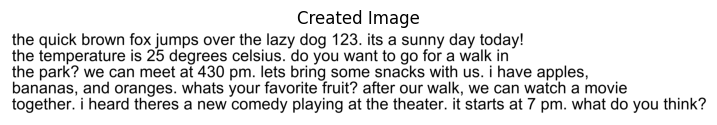

In [17]:
creator.create_text(test_text1, 'fonts/arial.ttf', 75, 'movie_big')
test_image1_big = Image.open('images/movie_big.png')
show_image(test_image1_big, 'Created Image', cmap='gray')

In [18]:
ocr.upload_font('fonts/arial.ttf', 75, 0.2)
text1_big = ocr.image_to_text(test_image1_big)
print(text1_big)

the quick brown fox jumps over the iazy dog 1l23. its a sunny day today!
the temperature is 25 degrees ceisius. do you want to go for a waik in
the park? we can meet at 430 pm. iets bring some snacks with us. i have appies,
bananas, and oranges. whats your favorite fruit? after our waik, we can watch a movie
together. i heard theres a new comedy piaying at the theater. it starts at 7 pm. what do you think?


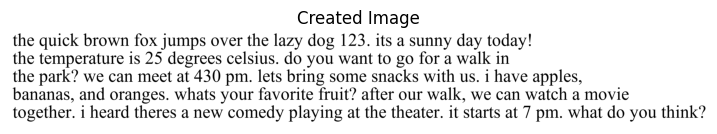

In [19]:
creator.create_text(test_text1, 'fonts/times.ttf', 75, 'movie_big_serif')
test_image1_big_serif = Image.open('images/movie_big_serif.png')
show_image(test_image1_big_serif, 'Created Image', cmap='gray')

In [20]:
ocr.upload_font('fonts/times.ttf', 75, 0.2)
text1_big_serif = ocr.image_to_text(test_image1_big_serif)
print(text1_big_serif)

the quick brown f .x jumps over the lazy dog 123. its a sunny day today!
the temperature is 25 degrees celsius. do you want to go f .r a walk in
the park? we can meet at 430 pm. lets bring some snacks with us. i have apples,
bananas, and oranges. whats your favorite f.uit? af er our walk, we can watch a movie
together. i heard theres a new comedy playing at the theater. it starts at 7 pm. what do you think?


In [21]:
print("Percents of similarity: ", change_to_procents(levenshtein_distance(test_text1, text1_big), test_text1, text1_big), "%")
print("Percents of similarity: ", change_to_procents(levenshtein_distance(test_text1, text1_big_serif), test_text1, text1_big_serif), "%")

Percents of similarity:  98.0440097799511 %
Percents of similarity:  98.53658536585365 %


The high test results affirm the effective functioning of the OCR.

## Rotation and noise

The class ```ImageParser``` was designed to address common issues found in images, such as rotation and noise.

The ```rotatio```n method detects the contours of the image, calculates the angle of rotation required to align the contours horizontally, and returns the rotated image accordingly. This ensures that the image is correctly oriented for further processing.

The ```remove_noise``` method utilizes the ```cv2.fastNlMeansDenoising``` function to reduce noise in the image. Function uses a non-local means denoising algorithm. The algorithm starts by analyzing the neighborhood around each pixel to determine how much they differ from each other. This similarity is calculated based on the differences in pixel intensities within a specified window or block. For each pixel in the image, the algorithm selects an appropriate reference pixel that is most similar to the currently analyzed pixel. Next, the algorithm computes a weighted average of the pixels around the reference pixel, with pixels having higher similarity weighted more heavily, and those with lower similarity weighted less. Finally, the reference pixel is replaced with its calculated weighted average value, effectively removing noise in the vicinity of the analyzed pixel.

By incorporating these methods, the ```ImageParser``` class provides robust functionality for preprocessing images, ensuring they are ready for accurate analysis and extraction of relevant information.

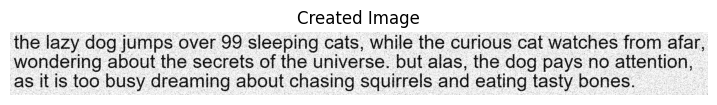

In [22]:
text_noise = 'the lazy dog jumps over 99 sleeping cats, while the curious cat watches from afar,\nwondering about the secrets of the universe. but alas, the dog pays no attention,\nas it is too busy dreaming about chasing squirrels and eating tasty bones.'
creator.create_text(text_noise, 'fonts/arial.ttf', 50, 'dog')
creator.add_noise('images/dog.png', 50)
noise_image = Image.open('images/dog.png')
show_image(noise_image, 'Created Image', cmap='gray')

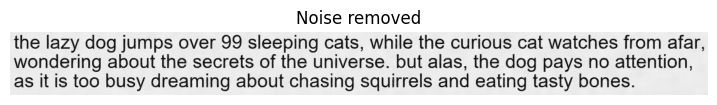

In [23]:
from parser.image_parser import ImageParser

parser = ImageParser()
noise_image = parser.remove_noise('images/dog.png')
show_image(noise_image, 'Noise removed', cmap='gray')

In [24]:
ocr.upload_font('fonts/arial.ttf', 50, 0.2, 0.86)
text = ocr.image_to_text(noise_image, 0.86, True)
print(text)

the !lazy dog jumps over 99 sieeping cats, whiie the curious cat watches from afar
wondering about the secrets of the universe. but ailas, the dog pays no attention,
as it is too busy dreaming about chasing squirre!ls and eating tasty bones.


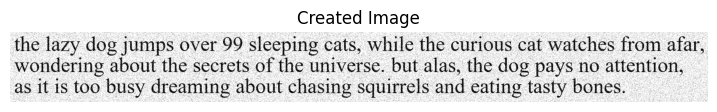

In [25]:
creator.create_text(text_noise, 'fonts/times.ttf', 50, 'dog_serif')
creator.add_noise('images/dog_serif.png', 50)
noise_image_serif = Image.open('images/dog_serif.png')
show_image(noise_image_serif, 'Created Image', cmap='gray')

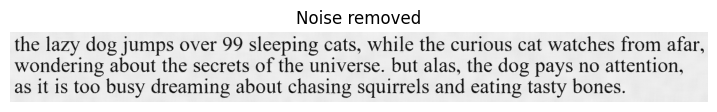

In [26]:
noise_image_serif = parser.remove_noise('images/dog_serif.png')
show_image(noise_image_serif, 'Noise removed', cmap='gray')

In [27]:
ocr.upload_font('fonts/times.ttf', 50, 0.2, 0.88)
text_serif = ocr.image_to_text(noise_image_serif, 0.88, True)
print(text_serif)

the lazy dogjumps over 99 sleeping cats, while the curious cat watches f1om afar,
wondering about the secrets ofthe universe. but alas, the dog pays no attention.
as it is too busy dreaming about chasing squirrels and eating tasty bones.


In [28]:
print("Percents of similarity: ", change_to_procents(levenshtein_distance(text_noise, text), text_noise, text), "%")
print("Percents of similarity: ", change_to_procents(levenshtein_distance(text_noise, text_serif), text_noise, text_serif), "%")

Percents of similarity:  97.5103734439834 %
Percents of similarity:  98.32635983263597 %


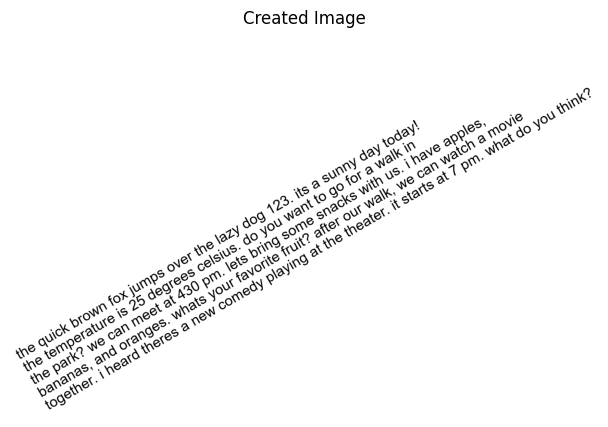

In [36]:
text_rotate = 'the quick brown fox jumps over the lazy dog 123. its a sunny day today!\nthe temperature is 25 degrees celsius. do you want to go for a walk in\nthe park? we can meet at 430 pm. lets bring some snacks with us. i have apples,\nbananas, and oranges. whats your favorite fruit? after our walk, we can watch a movie\ntogether. i heard theres a new comedy playing at the theater. it starts at 7 pm. what do you think?'
creator.create_text(text_rotate, 'fonts/arial.ttf', 50, 'dog_rotate')
creator.rotate_PIL('images/dog_rotate.png', 30)
rotated_image = Image.open('images/dog_rotate.png')
show_image(rotated_image, 'Created Image', cmap='gray')

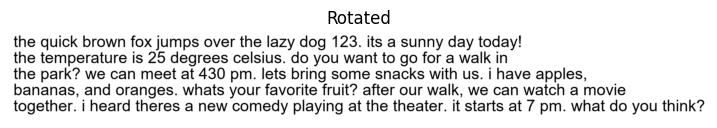

In [37]:
rotated_image = parser.rotation('images/dog_rotate.png')
show_image(rotated_image, 'Rotated', cmap='gray')

In [42]:
ocr.upload_font('fonts/arial.ttf', 50, 0.2, 0.912)
text = ocr.image_to_text(rotated_image, 0.912, noise=True)
print(text)

the quick brown fox jumps over the lazy dog 1 ?3. its a sunny day today!
the temperature is 25 degrees celsius. do you want to go for a walk in
the park? we can meet at 430 pm. lets bring some snacks with us. i have apples,
bananas, and oranges. whats your favorite fruit? after our walk, we can watch a movie
together i heard theres a new comedy playing at the theater. it starts at 7 pm. what do you think?


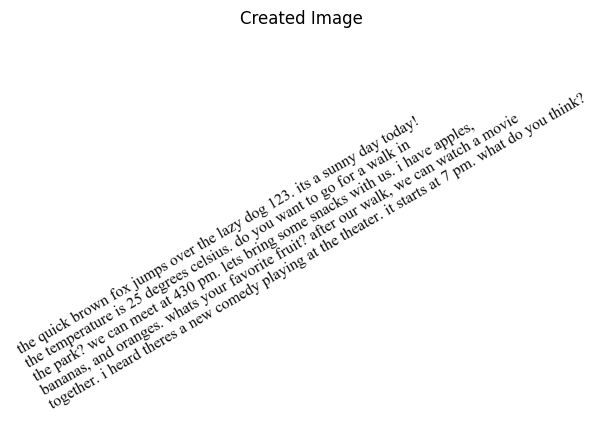

In [32]:
creator.create_text(text_rotate, 'fonts/times.ttf', 50, 'dog_rotate_serif')
creator.rotate_PIL('images/dog_rotate_serif.png', 30)
rotated_image_serif = Image.open('images/dog_rotate_serif.png')
show_image(rotated_image_serif, 'Created Image', cmap='gray')

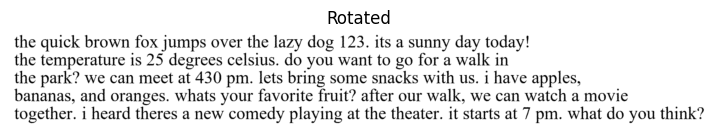

In [33]:
rotated_image_serif = parser.rotation('images/dog_rotate_serif.png')
show_image(rotated_image_serif, 'Rotated', cmap='gray')

In [34]:
ocr.upload_font('fonts/times.ttf', 50, 0.2, 0.912)
text_serif = ocr.image_to_text(rotated_image_serif, 0.912, noise=True)
print(text_serif)

the quick brown f .xjumps over the lazy dog 123 its a sunny day today!
the temperature is 25 degrees celsius do you want to go f..r a walk in
the park? we can meet at 430 pm iets bring some snacks with us i have apples,
bananas, and oranges whats your favorite f.uit? after our walk. we can watch a movie
together. i heard theres a new comedy playing at the theater it starts at 7 pm what do you think?


In [43]:
print("Percents of similarity: ", change_to_procents(levenshtein_distance(text_rotate, text), text_rotate, text), "%")
print("Percents of similarity: ", change_to_procents(levenshtein_distance(text_rotate, text_serif), text_rotate, text_serif), "%")

Percents of similarity:  99.26470588235294 %
Percents of similarity:  96.32352941176471 %


In summary, the OCR correctly detects the characters present in the image. To achieve better results for the extracted text, the detection sensitivity should be manually adjusted.